In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("NIFTY 50.csv")
data.head()

,date,open,high,low,close,volume
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0


In [3]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

data['open'] = data['open'].resample('3Min').first()
data['high'] = data['high'].resample('3Min').max()
data['low'] = data['low'].resample('3Min').min()
data['close'] = data['close'].resample('3Min').last()
data = data.dropna()

data = data.drop('volume', axis=1)
data['bar_marker'] = pd.Series()
data['sph_spl_marker'] = pd.Series()
data['place_order_marker'] = pd.Series()

data.head()

,open,high,low,close,bar_marker,sph_spl_marker,place_order_marker
date,,,,,,,
2015-01-09 09:15:00,8285.45,8295.90,8285.45,8293.90,NaN,NaN,NaN
2015-01-09 09:18:00,8294.25,8303.00,8293.90,8300.00,NaN,NaN,NaN
2015-01-09 09:21:00,8300.65,8302.90,8293.25,8294.70,NaN,NaN,NaN
2015-01-09 09:24:00,8295.20,8302.55,8289.45,8289.45,NaN,NaN,NaN
2015-01-09 09:27:00,8289.65,8294.15,8286.80,8294.15,NaN,NaN,NaN


In [4]:
data.loc[data.index[0],'bar_marker'] = 'AB'
searching_for = ''
place_order_lst = []
L_begin_index = -1
L_index = -1
H_begin_index = -1
H_index = -1

In [16]:
for i in range(13, 22):
    lowest_index = -1
    highest_index = -1
    ab_index = data.index.get_loc(data.loc[data['bar_marker'] == 'AB'].tail(1).index[0])

    if searching_for == '':  
        for prev in range(ab_index, i):
            if data.loc[data.index[prev], 'low'].item() > data.loc[data.index[i], 'low'].item() and data.loc[data.index[prev], 'close'].item() > data.loc[data.index[i], 'close'].item():
                data.loc[data.index[i], 'bar_marker'] = 'B1H'
                searching_for = 'B2H'
                if lowest_index == -1 or data.loc[data.index[prev], 'low'].item() < data.loc[data.index[lowest_index], 'low'].item():
                    lowest_index = prev   
                data.loc[data.index[lowest_index], 'bar_marker'] = 'AB'
            elif data.loc[data.index[prev], 'high'].item() < data.loc[data.index[i], 'high'].item() and data.loc[data.index[prev], 'close'].item() < data.loc[data.index[i], 'close'].item():
                data.loc[data.index[i], 'bar_marker'] = 'B1L'
                searching_for = 'B2L'
                if highest_index == -1 or data.loc[data.index[prev], 'high'].item() > data.loc[data.index[highest_index], 'high'].item():
                    highest_index = prev
                data.loc[data.index[highest_index], 'bar_marker'] = 'AB'
        continue

    if searching_for == 'B1H':
        for prev in range(ab_index, i):
            if data.loc[data.index[prev], 'low'].item() > data.loc[data.index[i], 'low'].item() and data.loc[data.index[prev], 'close'].item() > data.loc[data.index[i], 'close'].item():
                data.loc[data.index[i], 'bar_marker'] = 'B1H'
                searching_for = 'B2H'
                if lowest_index == -1 or data.loc[data.index[prev], 'low'].item() < data.loc[data.index[lowest_index], 'low'].item():
                    lowest_index = prev   
                data.loc[data['bar_marker'] == 'AB', 'bar_marker'] = 'AB_old'
                data.loc[data.index[lowest_index], 'bar_marker'] = 'AB'
        continue

    if searching_for == 'B2H':
        if data.loc[data['bar_marker'] == 'AB', 'low'].item() > data.loc[data.index[i], 'low'].item() and data.loc[data['bar_marker'] == 'AB', 'close'].item() > data.loc[data.index[i], 'close'].item():
            data.loc[data.index[i], 'bar_marker'] = 'B2H'        
            if len(data.loc[data['sph_spl_marker'] == 'L']) == 0:
                L_index = data.index.get_loc(data.iloc[0:i].loc[data['high'] == data.iloc[0:i]['high'].max(), 'sph_spl_marker'].index[0])
                data.loc[data.index[L_index], 'sph_spl_marker'] = 'H'
            else:
                L_begin_index = data.index.get_loc(data.loc[data['sph_spl_marker'] == 'L'].tail(1).index[0])
                L_index = data.index.get_loc(data.iloc[L_begin_index:i].loc[data['high'] == data.iloc[L_begin_index:i]['high'].max(), 'sph_spl_marker'].index[0])
                data.loc[data.index[L_index], 'sph_spl_marker'] = 'H'

            place_order_lst.append('H')
            if len(place_order_lst) == 3:
                if place_order_lst == ['H','L','H']:
                    data.loc[data.index[L_index], 'place_order_marker'] = 'Yes'
                del place_order_lst[0]       

            searching_for = 'B1L'
            data.loc[data['bar_marker'] == 'B1H', 'bar_marker'] = 'B1H_old'
            data.loc[data['bar_marker'] == 'AB', 'bar_marker'] = 'AB_old'
            data.loc[data['bar_marker'] == 'B2H', 'bar_marker'] = 'AB'
        else:
            for prev in range(ab_index, i):
                if data.loc[data.index[prev], 'low'].item() > data.loc[data.index[i], 'low'].item() and data.loc[data.index[prev], 'close'].item() > data.loc[data.index[i], 'close'].item():
                    data.loc[data.index[i], 'bar_marker'] = 'B1H'
                    searching_for = 'B2H'
                    if lowest_index == -1 or data.loc[data.index[prev], 'low'].item() < data.loc[data.index[lowest_index], 'low'].item():
                        lowest_index = prev   
                    data.loc[data['bar_marker'] == 'AB', 'bar_marker'] = 'AB_old'
                    data.loc[data.index[lowest_index], 'bar_marker'] = 'AB'
        continue

    if searching_for == 'B1L':
        for prev in range(ab_index, i):
            if data.loc[data.index[prev], 'high'].item() < data.loc[data.index[i], 'high'].item() and data.loc[data.index[prev], 'close'].item() < data.loc[data.index[i], 'close'].item():
                data.loc[data.index[i], 'bar_marker'] = 'B1L'
                searching_for = 'B2L'
                if highest_index == -1 or data.loc[data.index[prev], 'high'].item() > data.loc[data.index[highest_index], 'high'].item():
                    highest_index = prev
                data.loc[data['bar_marker'] == 'AB', 'bar_marker'] = 'AB_old'
                data.loc[data.index[highest_index], 'bar_marker'] = 'AB'
        continue

    if searching_for == 'B2L':
        if data.loc[data['bar_marker'] == 'AB', 'high'].item() < data.loc[data.index[i], 'high'].item() and data.loc[data['bar_marker'] == 'AB', 'close'].item() < data.loc[data.index[i], 'close'].item():
            data.loc[data.index[i], 'bar_marker'] = 'B2L'        
            if len(data.loc[data['sph_spl_marker'] == 'H']) == 0:
                H_index = data.index.get_loc(data.iloc[0:i].loc[data['low'] == data.iloc[0:i]['low'].min(), 'sph_spl_marker'].index[0])
                data.loc[data.index[H_index], 'sph_spl_marker'] = 'L'
            else:
                H_begin_index = data.index.get_loc(data.loc[data['sph_spl_marker'] == 'H'].tail(1).index[0])
                H_index = data.index.get_loc(data.iloc[H_begin_index:i].loc[data['low'] == data.iloc[H_begin_index:i]['low'].min(), 'sph_spl_marker'].index[0])
                data.loc[data.index[H_index], 'sph_spl_marker'] = 'L'  

            place_order_lst.append('L')
            if len(place_order_lst) == 3:
                if place_order_lst == ['L','H','L']:
                    data.loc[data.index[H_index], 'place_order_marker'] = 'Yes'
                del place_order_lst[0]

            searching_for = 'B1H'
            data.loc[data['bar_marker'] == 'B1L', 'bar_marker'] = 'B1L_old'
            data.loc[data['bar_marker'] == 'AB', 'bar_marker'] = 'AB_old'
            data.loc[data['bar_marker'] == 'B2L', 'bar_marker'] = 'AB'

        else:
            for prev in range(ab_index, i):
                if data.loc[data.index[prev], 'high'].item() < data.loc[data.index[i], 'high'].item() and data.loc[data.index[prev], 'close'].item() < data.loc[data.index[i], 'close'].item():
                    data.loc[data.index[i], 'bar_marker'] = 'B1L'
                    searching_for = 'B2L'
                    if highest_index == -1 or data.loc[data.index[prev], 'high'].item() > data.loc[data.index[highest_index], 'high'].item():
                        highest_index = prev
                    data.loc[data['bar_marker'] == 'AB', 'bar_marker'] = 'AB_old'
                    data.loc[data.index[highest_index], 'bar_marker'] = 'AB'
        continue

In [17]:
print('searching_for = ' + str(searching_for) + ' L_index = ' + str(L_index) + ' H_index = ' + str(H_index) + ' lowest_index = ' + str(lowest_index) + ' highest_index = ' + str(highest_index) + ' ab_index = ' + str(ab_index) + ' place_order_lst = ' + str(place_order_lst))

searching_for = B1H L_index = 16 H_index = 18 lowest_index = -1 highest_index = -1 ab_index = 18 place_order_lst = ['H', 'L']


In [20]:
data.iloc[0:30]

,open,high,low,close,bar_marker,sph_spl_marker,place_order_marker
date,,,,,,,
2015-01-09 09:15:00,8285.45,8295.90,8285.45,8293.90,AB_old,L,NaN
2015-01-09 09:18:00,8294.25,8303.00,8293.90,8300.00,B1L_old,H,NaN
2015-01-09 09:21:00,8300.65,8302.90,8293.25,8294.70,AB_old,NaN,NaN
2015-01-09 09:24:00,8295.20,8302.55,8289.45,8289.45,B1H_old,NaN,NaN
2015-01-09 09:27:00,8289.65,8294.15,8286.80,8294.15,AB_old,NaN,NaN
2015-01-09 09:30:00,8294.10,8295.75,8282.00,8283.10,NaN,NaN,NaN
2015-01-09 09:33:00,8282.75,8290.45,8280.65,8285.25,NaN,NaN,NaN
2015-01-09 09:36:00,8284.75,8287.55,8278.00,8282.55,AB_old,NaN,NaN
2015-01-09 09:39:00,8282.30,8288.30,8281.20,8285.60,B1L_old,NaN,NaN


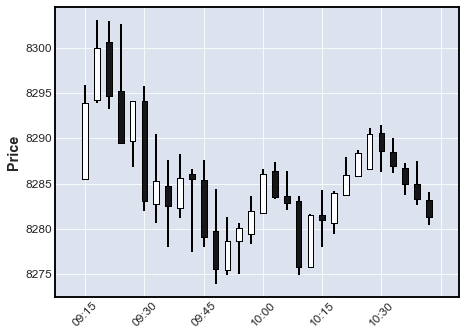

In [21]:
import mplfinance as mpf
import matplotlib.pyplot as plt

data_plt = data.copy()
data_plt.columns = ['Open', 'High', 'Low', 'Close', 'Bar_Marker', 'Sph_Spl_Marker', 'Place_Order_Marker']
mpf.plot(data_plt.iloc[0:30][['Open', 'High', 'Low', 'Close']], type='candlestick')

plt.show();